In [1]:
import numpy as np
from time import time
from lloyd import update_lloyd
from utils import calc_sq_distances
from kernel_utils import kernel_matrix
from quality_utils import calc_silhouettes
from elkan import update_elkan
start_elkan = update_lloyd #TODO 

In [2]:
class KKMeans():
    def __init__(self, n_clusters=8, init="random", n_init=3,
                 max_iter=300, tol=0, q_metric="inertia", verbose=False,
                 seed=None, algorithm="lloyd", kernel="linear", **kwargs):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.q_metric = q_metric
        self.verbose = verbose
        self.rng = np.random.default_rng(seed)
        self.algorithm = algorithm
        self.kernel = kernel
        self.kwargs = kwargs
        self.labels = None
        self.inner_sums = np.zeros(n_clusters, dtype=np.int_)
        self.cluster_sizes = None
        self.trained_data = None
        self.quality = None
    
    def kernel_wrapper(self, X, Y=None):
        return kernel_matrix(X, Y, kernel=self.kernel, **self.kwargs)

    def fit(self, X):
        
        X = self._sanitize_data(X)
        self._check_params(X)
        kernel_matrix = self.kernel_wrapper(X)
        
        labels_store = np.zeros((self.n_init, X.shape[0]), dtype=np.int_)
        quality_store = np.zeros(self.n_init, dtype=np.double)
        inner_sums_store = np.zeros((self.n_init, self.n_clusters), dtype=np.double)
        sizes_store = np.zeros((self.n_init, self.n_clusters), dtype=np.int_)
        
        for init in range(self.n_init):
            start_labels = self._init_labels(X, kernel_matrix)
            if self.algorithm == "lloyd":
                labels, quality, inner_sums, sizes = self._lloyd(kernel_matrix, start_labels)
            elif self.algorithm == "elkan":
                labels, quality, inner_sums, sizes = self._elkan(kernel_matrix, start_labels)
            else:
                raise ValueError(self.algorithm + " algorithm not implemented")
            labels_store[init] = labels
            quality_store[init] = quality
            inner_sums_store[init] = inner_sums
            sizes_store[init] = sizes

        best_init = self._get_best_init(quality_store)
        self.labels = labels_store[best_init]
        self.inner_sums = inner_sums_store[best_init]
        self.cluster_sizes = sizes_store[best_init]
        self.quality = quality_store[best_init]
        self.trained_data = X
        
        if self.verbose:
            print("Best " + self.q_metric +":", self.quality,
                "Found at init:", best_init + 1)

    def _check_params(self, data):
        if self.algorithm == "elkan" and self.q_metric == "silhouette":
            print("WARNING: using silhouette as metric with elkan will most likely be inaccurate\
                  as elkan  does not calculate exact distances to every center")
        if self.n_init <= 0:
            raise ValueError("n_inits needs to be at least 1")

        if data.shape[0] <  self.n_clusters:
            raise ValueError("sample:cluster ratio needs to be at least one")
        


        
    def _get_best_init(self, quality_store):
        if self.q_metric == "inertia":
            return np.argmin(quality_store)
        elif self.q_metric == "silhouette":
            return np.argmax(quality_store)
        else:
            raise Exception("Quality metric not implemented. This should never occur.")


    def _sanitize_data(self, X):
        X = np.asarray(X, dtype=np.double)
        if len(X.shape) != 2:
            raise ValueError("X needs to be 2-d Array")
        if 0 in X.shape:
            raise ValueError("X is empty")
        return X
    
    def _init_labels(self, X, kernel_matrix):
        '''Assign labels to each datapoint by given method'''
        if isinstance(self.init, (list, tuple, np.ndarray)):
            self.init = self._sanitize_centers() 
            return self._assign_to_centers(X, self.init)
        
        elif self.init == "random":
            centers = self.rng.choice(X, self.n_clusters)
            return self._assign_to_centers(X, centers)
        elif self.init == "truerandom":
            return self.rng.integers(0, self.n_clusters, len(X), dtype=np.int_)
        
        elif self.init == "kmeans++":
            return self._kmeanspp(X, kernel_matrix)
        
        raise NotImplementedError("Unknown initialisation method")
    
    def _sanitize_centers(self, centers):
        centers = np.asarray(centers, dtype=np.double)
        if len(centers.shape) != 2:
            raise ValueError("Given centers need to be 2-d array")
        if 0 in centers.shape:
            raise ValueError("Given centers are empty")
        if len(centers) != self.n_clusters:
            raise ValueError("Amount of given centers must be equal to n_clusters")
        return centers
        
    def _assign_to_centers(self, X, centers):
        X_center_kernel = self.kernel_wrapper(X, centers)
        dists_to_centers = np.zeros((len(X), self.n_clusters))
        for cluster in range(self.n_clusters):
            dists_to_centers[:, cluster] = (-2 * X_center_kernel[:, cluster]
                             + self.kernel_wrapper(centers[cluster]))
        return np.array(np.argmin(dists_to_centers, axis=1), dtype=np.int_)

    def _kmeanspp(self, X, kernel_matrix):
        dists_to_centers = self._build_starting_distance(kernel_matrix)
        data_size = X.shape[0]
        for cluster in range(self.n_clusters):
            if cluster == 0:
                index = self.rng.integers(low=0, high=data_size)
            else:
                max_dist_each = np.amin(dists_to_centers[:, :cluster + 1], axis = 1)
                probs = max_dist_each/max_dist_each.sum()
                index = self.rng.choice(len(X), size=1, p=probs)
            center = X[index]
            inner_sum = self.kernel_wrapper(center)
            outer_sum = self.kernel_wrapper(X, center)
            # reshape necessary as kernel_wrapper has 2dim array output
            dists_to_centers[:, cluster] += (-2 * outer_sum + inner_sum).reshape(data_size,)
            dists_to_centers[:, cluster] = np.sqrt(dists_to_centers[:, cluster])
             
            
        return np.array(np.argmin(dists_to_centers, axis=1), dtype=np.int_)

    def _lloyd(self, kernel_matrix, labels):
        quality = 0
        for it in range(self.max_iter):
            distances = self._build_starting_distance(kernel_matrix)
            distances, inner_sums, cluster_sizes =\
                    update_lloyd(distances, kernel_matrix, labels, self.n_clusters)
            labels_old = labels
            labels = np.asarray(np.argmin(distances, axis=1), dtype=np.int_)
            
            quality, converged = self.measure_iter(distances, labels, labels_old, quality)
            self._out_verbose(it, quality, converged=converged)
            if converged:
                break
        
        return labels, quality, inner_sums, cluster_sizes
    


    def _out_verbose(self, iter, quality, converged):
        if not self.verbose:
            return
        if converged:
            print("Converged at iteration:", iter + 1, self.q_metric + ":", quality)
        elif self.tol == 0:
            print("Iteration:", iter + 1, self.q_metric + ":", "Not calculated (Tol==0)")
        else:
            print("Iteration:", iter + 1, self.q_metric + ":", quality)
    
    def predict(self, X):
        kernel_matrix = self.kernel_wrapper(X, self.trained_data)
        sq_distances = calc_sq_distances(self.inner_sums, 
                                  self.cluster_sizes,
                                  kernel_matrix,
                                  self.labels, 
                                  self.n_clusters)
        return np.argmin(np.sqrt(sq_distances), axis=1)
    
    def measure_iter(self, sq_distances, labels, labels_old, quality):
        converged = False
        if self.tol != 0:
            quality_old = quality
            quality = self._calc_q_metric(sq_distances, labels)
            if abs(quality - quality_old) <= self.tol:
                converged = True

        if all(labels_old == labels):
            if self.tol == 0:
                quality = self._calc_q_metric(sq_distances, labels)
            converged = True
        
        return quality, converged

    def _calc_q_metric(self, sq_distances, labels):
        if self.q_metric == "inertia":
            return sq_distances[range(sq_distances.shape[0]), labels].sum()
        elif self.q_metric == "silhouette":
            return self.calc_silhouette(sq_distances, labels)
        else:
            raise NotImplementedError(str(self.q_metric) + " quality metric not implemented")
            
    def calc_silhouette(self, sq_distances, labels):
        dists = np.sqrt(sq_distances)
        silhouettes = calc_silhouettes(dists, labels)
        return sum(silhouettes) / len(silhouettes)
    
    def _build_starting_distance(self, kernel_matrix):
        return np.ascontiguousarray(np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T, dtype=np.double)

    def _elkan(self, kernel_matrix, labels):
        labels = np.array(labels, dtype=np.int_) # TODO delete and change dtype in init_labels
        start_dists = self._build_starting_distance(kernel_matrix)
        center_dists = np.zeros((kernel_matrix.shape[0], self.n_clusters))
        quality = 0
        for it in range(self.max_iter):
            if it == 0:
                l_bounds, inner_sums, sizes = start_elkan(start_dists, kernel_matrix, labels, self.n_clusters)
            else:
                l_bounds, inner_sums, sizes, center_dists = update_elkan(kernel_matrix, l_bounds, center_dists, labels, labels_old, sizes, inner_sums, self.n_clusters)

            labels_old = labels
            labels = np.array(np.argmin(l_bounds, axis=1), dtype=np.int_)
            
            quality, converged = self.measure_iter(l_bounds, labels, labels_old, quality)
            self._out_verbose(it, quality, converged=converged)
            if converged:
                break

        return labels, quality, inner_sums, sizes



In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans

In [4]:
def visualize(data, labels):
    if len(data[0]) > 3:
        raise Exception("Dimensionality is too high for visualization")
    elif len(data[0]) == 1:
        plt.scatter(data, [0 for x in range(len(data))], c = labels)
    elif len(data[0]) == 2:
        plt.scatter(data[:,0], data[:,1], c = labels)
    elif len(data[0]) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection = "3d")
        ax.scatter(data[:,0], data[:,1], data[:,2], c = labels)

In [5]:
x, labels, centers = make_blobs(10000, centers=5, return_centers = True, random_state = 0, n_features = 2)

In [8]:
kkm = KKMeans(n_clusters = 5, verbose = False, init = "kmeans++", kernel = "linear", seed = 0, q_metric="inertia", n_init=3, tol = 1e-4, algorithm="elkan")

2.6947529315948486


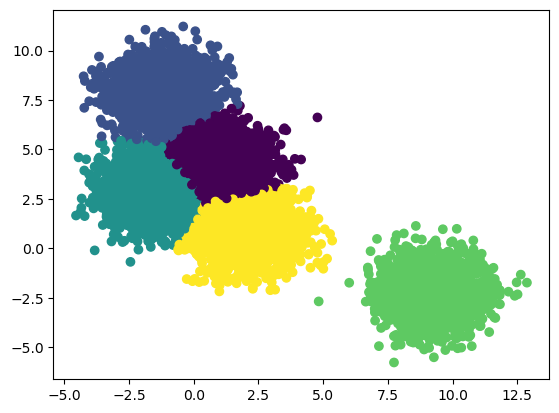

In [9]:
start = time()
kkm.fit(x)
end = time()
print(end - start)
visualize(x, kkm.labels)

In [14]:
x, l = make_circles(7000, factor = 0.4, random_state=0)

In [15]:
kkm = KKMeans(n_clusters = 2, verbose = True, init = "kmeans++", kernel = "rbf", seed = 0, tol = 1e-4, variance=0.4, n_init = 5, q_metric="inertia", algorithm="lloyd")

Converged at iteration: 1 inertia: 5661.005505994073
Iteration: 1 inertia: 5784.662011156155
Iteration: 2 inertia: 5767.460826662198
Iteration: 3 inertia: 5759.2393058095095
Iteration: 4 inertia: 5750.70361841647
Iteration: 5 inertia: 5741.790134714787
Iteration: 6 inertia: 5732.256515618136
Iteration: 7 inertia: 5722.0163128715
Iteration: 8 inertia: 5710.96651599458
Iteration: 9 inertia: 5698.794230702577
Iteration: 10 inertia: 5685.128307401199
Iteration: 11 inertia: 5669.50953923946
Iteration: 12 inertia: 5651.575134306451
Iteration: 13 inertia: 5630.099221062976
Iteration: 14 inertia: 5603.364955370463
Iteration: 15 inertia: 5551.916298572699
Converged at iteration: 16 inertia: 5521.144117944171
Iteration: 1 inertia: 5776.649553919222
Iteration: 2 inertia: 5768.493305417622
Iteration: 3 inertia: 5760.264146791457
Iteration: 4 inertia: 5751.728308210113
Iteration: 5 inertia: 5742.822639542299
Iteration: 6 inertia: 5733.304047380167
Iteration: 7 inertia: 5723.086337689017
Iteration: 

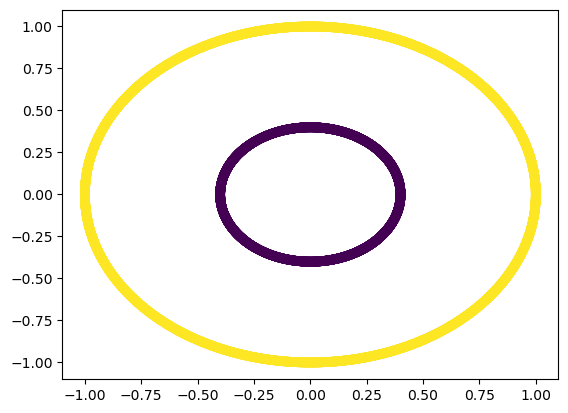

In [16]:
start = time()
kkm.fit(x)
end = time()
print(end - start)
visualize(x, kkm.labels)

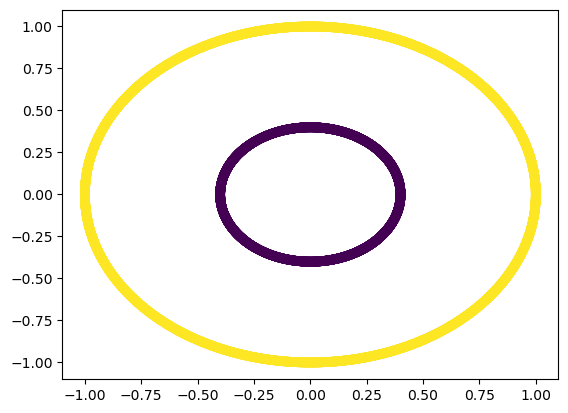

In [17]:
visualize(x, kkm.predict(x))

In [18]:
all(kkm.predict(x) == kkm.labels)

True

In [19]:
x, labels, centers = make_blobs(5000, centers=200, return_centers = True, random_state = 0, n_features = 2)

In [20]:
kkml =  KKMeans(n_clusters = 200, verbose = True, init = "kmeans++", kernel = "linear", seed = 0, tol = 1e-4, n_init = 3, q_metric="inertia", algorithm="lloyd")
kkme =  KKMeans(n_clusters = 200, verbose = True, init = "kmeans++", kernel = "linear", seed = 0, tol = 1e-4, n_init = 3, q_metric="inertia", algorithm="elkan")

Iteration: 1 inertia: 2100.1711850952897
Iteration: 2 inertia: 1933.1057313077135
Iteration: 3 inertia: 1856.8116506287638
Iteration: 4 inertia: 1815.265118392983
Iteration: 5 inertia: 1787.2188852791874
Iteration: 6 inertia: 1771.852910769675
Iteration: 7 inertia: 1759.72227254862
Iteration: 8 inertia: 1751.21683240841
Iteration: 9 inertia: 1745.0903560599413
Iteration: 10 inertia: 1740.30102081318
Iteration: 11 inertia: 1738.242818127787
Iteration: 12 inertia: 1736.38387459237
Iteration: 13 inertia: 1732.7322828465108
Iteration: 14 inertia: 1730.3735628743386
Iteration: 15 inertia: 1727.818899398119
Iteration: 16 inertia: 1726.4768752376553
Iteration: 17 inertia: 1726.0281129446716
Converged at iteration: 18 inertia: 1725.95485925606
Iteration: 1 inertia: 2137.481452039642
Iteration: 2 inertia: 1971.957319637403
Iteration: 3 inertia: 1911.2033843405156
Iteration: 4 inertia: 1870.243433459213
Iteration: 5 inertia: 1838.8402975606505
Iteration: 6 inertia: 1820.6828026950739
Iteration: 

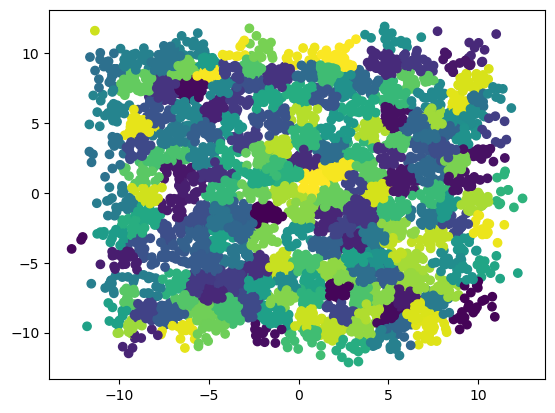

In [21]:
start = time()
kkml.fit(x)
end = time()
print(end - start)
visualize(x, kkml.labels)

Iteration: 1 inertia: 2100.1711850952897
Iteration: 2 inertia: 1933.1057313077133
Iteration: 3 inertia: 1856.8116506287638
Iteration: 4 inertia: 1815.265118392983
Iteration: 5 inertia: 1787.2188852791874
Iteration: 6 inertia: 1771.852910769675
Iteration: 7 inertia: 1759.7222725486195
Iteration: 8 inertia: 1751.2168324084098
Iteration: 9 inertia: 1745.090356059941
Iteration: 10 inertia: 1740.30102081318
Iteration: 11 inertia: 1738.2428181277867
Iteration: 12 inertia: 1736.3838745923697
Iteration: 13 inertia: 1732.7322828465108
Iteration: 14 inertia: 1730.3735628743384
Iteration: 15 inertia: 1727.818899398119
Iteration: 16 inertia: 1726.476875237655
Iteration: 17 inertia: 1726.0281129446716
Converged at iteration: 18 inertia: 1725.95485925606
Iteration: 1 inertia: 2137.481452039642
Iteration: 2 inertia: 1971.9573196374033
Iteration: 3 inertia: 1911.2033843405154
Iteration: 4 inertia: 1870.2434334592126
Iteration: 5 inertia: 1838.8402975606505
Iteration: 6 inertia: 1820.6828026950736
Iter

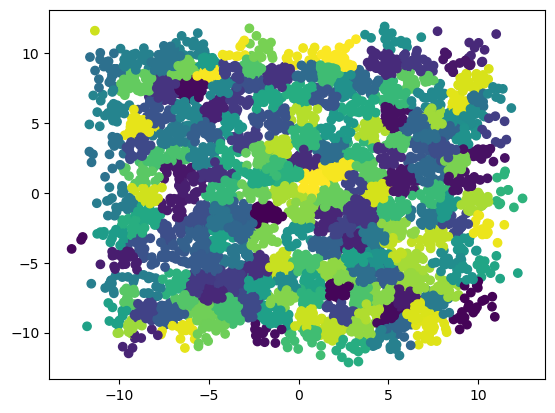

In [22]:
start = time()
kkme.fit(x)
end = time()
print(end - start)
visualize(x, kkme.labels)

In [23]:
print(all(kkme.labels == kkml.labels))

True
